In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
# ignore all warnings
warnings.filterwarnings('ignore')
import matplotlib.dates as mdates
# from matplotlib.dates import bytespdate2num

## 1 Load the data set

In [29]:
df = pd.read_csv("corona_tested_individuals_ver_00166.csv", header=0) ## load the date in local
# df_np = np.loadtxt('corona_tested_individuals_ver_00166.csv', delimiter=',', skiprows=1,
#                           usecols= (1,7), unpack=True)
# df = pd.DataFrame(df)
# columns = ['test_date','cough','fever','sore_throat','shortness_of_breath','head_ache','corona_result','age_60_and_above','gender','test_indication'
df = df.drop(['test_date'], axis = 1)

## Data Exploration¶

In [ ]:
df.head()

In [ ]:
df.info()

In [27]:
pd.concat([
    df.describe().T,
    df.mad().rename('mad'),
    df.skew().rename('skew'),
    df.kurt().rename('kurt'),
    df.nunique().rename('nunique')
], axis=1).T

In [24]:
df.plot.box(vert=False, figsize=(5, 10));

Explanation of the data:
https://data.gov.il/dataset/covid-19/resource/0ac4cffc-3746-473a-8d4a-ab874b8d8d62

Gender: appears fromMarch22nd2020

Corona_result: Results of first Covid-19 test, by category:
    a.Positive –carrying Covid-19
    b.Negative –not carrying Covid-19
    c.Other –Not tested, in testing, inconclusive

Age_60_and_above: Indicator of the test taker'sage -60 or over (1) or below 60 (0). Appears from March17th2020.

Test_indication: What is the indication for testing? Abroad –arrived from abroad, contact_with_confirmed –contact with aconfirmed case, other –other indication or not specified

Symptoms (whether developed before testing):
cough, fever, sore_throat, shortness of breath, headache: 1 –Yes, 0–No, NULL –Unknown

Obviously, the corona_result is the label class.

Here we have questions on 1) how to handle missing age values before March 22 and age before March 17. 2)null values (drop or replace) 3) the meaningful use of test date data

In [46]:
df['corona_result'].unique() 

array(['שלילי', 'אחר', 'חיובי'], dtype=object)

In [13]:
# replacing all the characters in Hebrew
df['corona_result'] = df['corona_result'].str.replace('חיובי','Positive')
df['corona_result'] = df['corona_result'].str.replace('אחר','Other')
df['corona_result'] = df['corona_result'].str.replace('שלילי','Negative')

df['gender'] = df['gender'].str.replace('נקבה','Female')
df['gender'] = df['gender'].str.replace('זכר','Male')

# y = y.str.replace('שלילי','Negative') why series can't use replace???

In [161]:
# the below returns Error ConnectTimeout: timed out

# from googletrans import Translator
# translator = Translator()         

In [162]:
# df['corona_result_en'] = df['corona_result'].apply(translator.translate, src='he', dest='en').apply(getattr, args=('text',))

In [163]:
df['test_date'] = pd.to_datetime(df['test_date'],format='%Y-%m-%d')

In [31]:
y = df['corona_result']
X = df.drop(['corona_result'], axis = 1)
X.head()

In [30]:
sns.countplot(y,label="Count");

In [166]:
# color_function = {0: "blue", 1: "red", 2: "orange"} # Here Red color will be 1 which means M and blue foo 0 means B
# colors = y.map(lambda x: color_function.get(x)) c=colors,
# pd.plotting.scatter_matrix(df, alpha = 0.5, figsize = (15, 15)); 

## Imputation

In [15]:
# How many features have missing values?
n_missing = len(df.columns[df.isnull().any()])
"{} features have missing values.".format(n_missing)

'2 features have missing values.'

In [16]:
keys = ['Total', 'Percent']

null_total = df.isnull().sum().sort_values(ascending=False)
null_percent = (df.isnull().sum() /df.isnull().count())

df_missing = pd.concat([null_total, null_percent], axis=1, keys=keys, sort=False)
df_missing = df_missing.sort_values(by='Percent', ascending=False)
df_missing.head(n_missing)

,Total,Percent
age_60_and_above,1265192,0.201983
gender,1062484,0.169622


The percentage of the missing values is large. We will test on filled and dropped datasets and see if one improves the accuracy

In [17]:
# replace the missing value
X_filled = X.copy()
X_filled_nom = X_filled.select_dtypes(include=[object])
X_filled_num = X_filled.select_dtypes(include=[np.number])

X_filled[X_filled_nom.columns] = X_filled_nom.fillna('Missing')
X_filled.head()

,cough,fever,sore_throat,shortness_of_breath,head_ache,age_60_and_above,gender,test_indication
0,0,0,0,0,0,No,Female,Other
1,0,0,0,0,0,No,Female,Other
2,1,1,1,0,1,No,Female,Abroad
3,0,0,0,0,0,No,Male,Other
4,0,0,0,0,0,No,Female,Other


In [18]:
# drop the rows with missing value
X_dropped = X.dropna(how='any',axis=0) 

In [19]:
n_missing = len(X_dropped.columns[X_dropped.isnull().any()])
"{} features have missing values.".format(n_missing)

'0 features have missing values.'

In [20]:
X_dropped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4526629 entries, 0 to 6241984
Data columns (total 8 columns):
 #   Column               Dtype 
---  ------               ----- 
 0   cough                int64 
 1   fever                int64 
 2   sore_throat          int64 
 3   shortness_of_breath  int64 
 4   head_ache            int64 
 5   age_60_and_above     object
 6   gender               object
 7   test_indication      object
dtypes: int64(5), object(3)
memory usage: 310.8+ MB


## Feature selection

In [173]:
# corr for mean
corr = df.corr() 

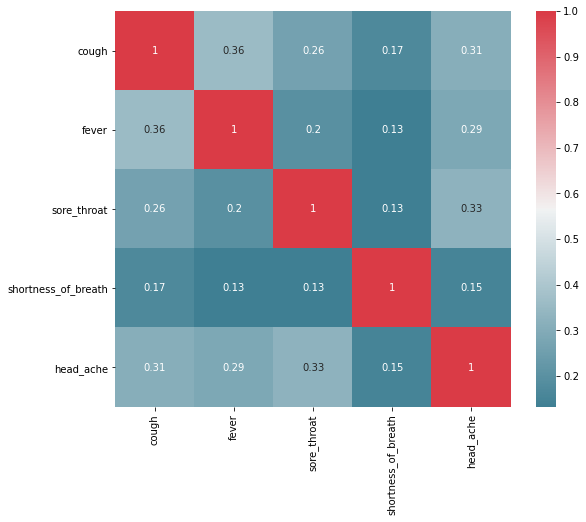

In [174]:
# why there's no correlation for categorical features?
plt.rc("figure", figsize=(10, 10))
grid=sns.heatmap(corr,annot=True,cbar = True, square = True, cmap=sns.diverging_palette(220, 10, as_cmap=True))
grid.set_xticklabels(corr.columns,rotation=90)
plt.subplots_adjust(left=0.3,right=1,bottom=0.35,top=0.9)
plt.show()

Findings: The correlations between any two features are low.

In [26]:
# x = X_dropped[["sore_throat"]]
# col = list(x.columns)
# x[col] = x[col].apply(pd.to_numeric, errors='coerce').fillna(0.0)
# # x['fever'] = x['fever'].apply(pd.to_numeric, errors='coerce').fillna(0.0)
# for a in x["sore_throat"]:
#     try:
#         a.contains('Negative')
#         print("Input is a valid number")
#     except:
#         print("Input must be a valid number. Non-special characters, commas and spaces are not accepted.")

In [22]:
# TO DO
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mutual_info_score
X_numeric = X_dropped[X_dropped.select_dtypes(include=[np.number]).columns]
mi = mutual_info_regression(X_numeric, y, n_neighbors=1, random_state=0)
mi

ValueError: could not convert string to float: 'Negative'

https://www.kaggle.com/kanncaa1/feature-selection-and-data-visualization

In [115]:
# TO DO
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import accuracy_score

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#random forest classifier with n_estimators=10 (default)
clf_rf = RandomForestClassifier(random_state=0)      
clr_rf = clf_rf.fit(x_train,y_train)

ac = accuracy_score(y_test,clf_rf.predict(x_test))
print('Accuracy is: ',ac)
cm = confusion_matrix(y_test,clf_rf.predict(x_test))
sns.heatmap(cm,annot=True,fmt="d")

ValueError: could not convert string to float: 'No'

## Standardization

In [57]:
# from sklearn.preprocessing import scale
# X_scaled = X.copy()
# X_scaled_numeric = X_scaled.select_dtypes(include=[np.number])
# for col in X_scaled_numeric.columns:
#     X_scaled[col] = scale(X_scaled[col], axis=0, with_mean=True, with_std=True)
# X_scaled.head()

In [32]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()

# X_scaled = X.copy()

# # get numeric data
# num_d = X_scaled.select_dtypes(include=[np.number])

# # update the cols with their normalized values
# X_scaled[num_d.columns] = scaler.fit_transform(num_d)

# # convert string variable to One Hot Encoding
# X_scaled = pd.get_dummies(X_scaled) #OneHotEncoder() process string values directly.

# X_scaled.head()

In [ ]:
X_scaled.plot.box(vert=False, figsize=(8, 18));

In [ ]:
X.plot.box(vert=False, figsize=(8, 18));

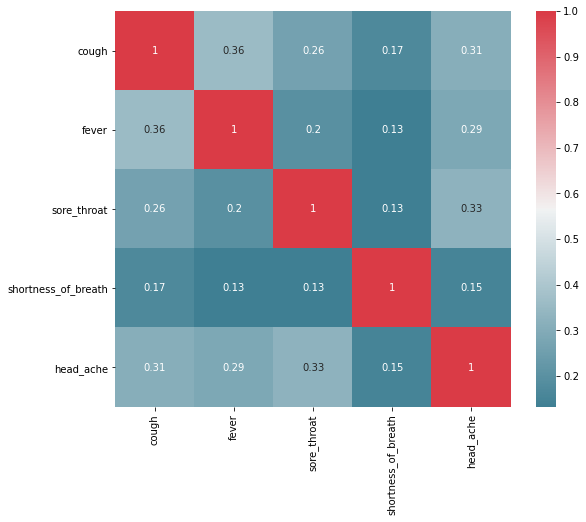

In [61]:
# still no categorical features
corr = X_scaled.corr()
plt.rc("figure", figsize=(10, 10))
grid=sns.heatmap(corr,annot=True,cbar = True, square = True, cmap=sns.diverging_palette(220, 10, as_cmap=True))
grid.set_xticklabels(corr.columns,rotation=90)
plt.subplots_adjust(left=0.3,right=1,bottom=0.35,top=0.9)
plt.show()